# Bayesian optimization and GMM model experiments
Log-likelihood optimization for GMM model can't be done directly with gradient methods.
Traditionally some lower bounds are introduced and optimized instead. For example, EM-algorithm was invented in this way.

However, it's interesting to try gradient-free methods for optimization. In this tutorial let's challenge BO with this.

First let's make samples from GMM model. Choose means and covariances randomly.

In [2]:
import numpy as np
import scipy

def get_cov_2d(lambdas=None, theta=None):
    
    if lambdas is None and theta is None:
        theta = np.random.uniform(0, 2*np.pi)
        lambdas = 0.005*np.random.uniform(0, 1, 2)
    rt = [[np.cos(theta), -np.sin(theta)],
          [np.sin(theta), np.cos(theta)]]
    rt = np.array(rt)    
    return rt @ np.diag(lambdas) @ rt.T

np.random.seed(1023)

clusters, dim = 3, 2
mean, cov = [], []

for i in range(0, clusters):
    mean.append(np.random.uniform(0, 1, dim))
    cov.append(get_cov_2d())    

print(mean, cov)

mean, cov = np.array(mean), np.array(cov)
samples, size = [], 100

for i in range(0, clusters):
    for j in range(0, size):
        samples.append(np.random.multivariate_normal(mean[i], cov[i]))    
        
samples = np.array(samples)

[array([0.91406979, 0.63007121]), array([0.73333206, 0.66635096]), array([0.6483029 , 0.90287707])] [array([[2.64283345e-04, 3.61515054e-06],
       [3.61515054e-06, 2.00146331e-04]]), array([[0.00257294, 0.00127945],
       [0.00127945, 0.00162793]]), array([[0.00190634, 0.00059158],
       [0.00059158, 0.00069795]])]


Then plot samples and true model means.

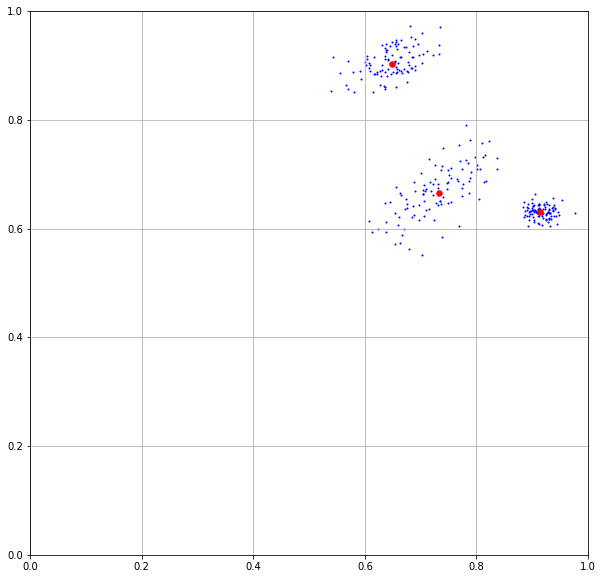

In [3]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 10]

fig, ax = plt.subplots()

ax.scatter(samples[:, 0], samples[:, 1], color='blue', s=1)
ax.scatter(mean[:, 0], mean[:, 1], color='red', s=30)

ax.set_xlim((0, 1))
ax.set_ylim((0, 1))
ax.grid(True)

plt.show()


Let's create GMMLikelihoodDispatch class for managing parameters substitution into exact log-likelihood function.
There is K weights, 2K mean parameters and 3K (pair of eigenvalues and rotation angle), where K is number of clusters.

This class should know true parameters and substitute them with input variables when it's required.
Also it makes some reparametrization for positive only parameters, like probability weights and covariance eigenvalues.

In [4]:
from scipy.stats import multivariate_normal
from collections import defaultdict

def exact_GMM_log_likelihood(w, mean, cov, samples):
    K = w.shape[0]    
    inner = np.zeros(len(samples))
    
    for k in range(0, K):
        inner += w[k] * multivariate_normal.pdf(samples, mean[k], cov[k])
    
    outer = np.sum(np.log(inner))
     
    if outer < -1e7 or np.isnan(outer):
        outer = -1e7

    return outer

class GMMLikelihoodDispatch:
    
    def __init__(self, clusters, samples, hints):
        self.clusters = clusters
        self.samples = samples
        self.hints = defaultdict(list, hints)
    
    def unpack_cov(self, theta):        
        theta = np.array(theta)        
        cov = theta.reshape(self.clusters, 3)        
        cov_ = []
        
        for j in range(0, self.clusters):
            cov_expand = get_cov_2d([cov[j, 0]**2, cov[j, 1]**2], cov[j, 2]) #ensure positive sd
            cov_.append(np.array(cov_expand))
    
        return np.array(cov_)
    
    def unpack_mean(self, theta):
        theta = np.array(theta)
        return theta.reshape(self.clusters, 2)
        
    def unpack_w(self, theta):
        theta = np.array(theta)
        return theta**2/np.sum(theta**2)
        
    def process_params(self, d):
        params = defaultdict(list, {})
        
        for k, v in d.items():
            label, idx = k.split('_')
            params[label].append((v, idx))

        for label in params.keys():
            params[label] = [item[0] for item in sorted(params[label], key = lambda x: x[1])]

        return params

    def compute(self, params):
        self.unpack(params)        
        return exact_GMM_log_likelihood(self.w, self.mean, self.cov, self.samples)
    
    def unpack(self, params):
        params = self.process_params(params)
        self.w = self.hints['w'] if len(params['w']) < 1 else self.unpack_w(params['w'])
        self.mean = self.hints['mean'] if len(params['mean']) < 1 else self.unpack_mean(params['mean'])
        self.cov = self.hints['cov'] if len(params['cov']) < 1 else self.unpack_cov(params['cov'])
        return (self.w, self.mean, self.cov)
        
        

Let's compute several log-likelihood values for random parameters.

In [5]:
hints = {'w': np.ones(clusters)/clusters, 'mean': mean, 'cov': cov}
#print(hints)

gmm = GMMLikelihoodDispatch(clusters, samples, hints)

for i in range(0, 10):
    params = {} 
    
    for i in range(0, 3*clusters):
        params[f'cov_{i}'] = np.random.uniform(0, 10)
    
    for i in range(0, clusters):
        params[f'w_{i}'] = np.random.uniform(0, 10)
   
    for i in range(0, 2*clusters):
        params[f'mean_{i}'] = np.random.uniform(0, 10)
    
    #print(params)
    
    L = gmm.compute(params)
    
    print(L)        
        
print(gmm.compute({}))

-1776.8969468398263
-2039.2588441543235
-2088.1567492425165
-2154.682128952763
-1802.6280724038875
-1859.8991028409293
-3537.799855094538
-1865.3636386624462
-2170.9316681991368
-2018.9878581538837
981.4677934541686


Then let's fix true covariances and weights and optimize only centers (2K-dimentional problem). Use BO from bayes_opt package. Compute several trajectories (! it requires time).

In [6]:
from bayes_opt import BayesianOptimization, UtilityFunction, SequentialDomainReductionTransformer


def L_patched(**params):
    hints = {'w': np.ones(clusters)/clusters, 'mean': mean, 'cov': cov}
    gmm = GMMLikelihoodDispatch(clusters, samples, hints)
    return gmm.compute(params)/1e3
    

def run_experiment(seed):
    print('seed: ', seed)

    pbounds = {}
    '''
    for i in range(0, 3*clusters):
        pbounds[f'cov_{i}'] = (-10, 10)

    for i in range(0, clusters):
        pbounds[f'w_{i}'] = (0, 10)
    '''
    for i in range(0, 2*clusters):
        pbounds[f'mean_{i}'] = (0.6, 1)
    
    acq_function = UtilityFunction(kind="ucb", kappa=0.05)
    #bounds_transformer = SequentialDomainReductionTransformer(minimum_window=0.1)

    optimizer = BayesianOptimization( f = L_patched, 
                                      pbounds = pbounds,
                                      random_state = seed,
                                      allow_duplicate_points=True,
                                      verbose=0,
                                      #bounds_transformer=bounds_transformer
                                    )

    rng = np.random.default_rng()
    subset_size = 25

    for i in range(0, subset_size):
        params_test = {}
        sample_choice = rng.choice(samples, 3, replace=False)
        for j in range(0, 2 * clusters):
            params_test[f'mean_{j}'] = sample_choice[j//2, j%2]
        optimizer.probe(params=params_test, lazy=True)

    optimizer.set_gp_params(alpha=1e-3, n_restarts_optimizer=5)
    optimizer.maximize(init_points=0, n_iter=100, acquisition_function=acq_function) #50, 250

    #print(optimizer.res)
    
    res = np.array([item['target'] for item in optimizer.res])
    trajectory = np.maximum.accumulate(res)

    return optimizer, trajectory

seeds = np.random.choice(1000, 10, replace=False).tolist()
print(seeds)

results, opt_data = [], []

for seed in seeds:
    opt, trajectory = run_experiment(seed)
    
    results.append(trajectory)
    opt_data.append(opt)
    

[804, 350, 31, 435, 57, 549, 906, 323, 280, 690]
seed:  804
seed:  350
seed:  31
seed:  435
seed:  57
seed:  549
seed:  906
seed:  323
seed:  280
seed:  690


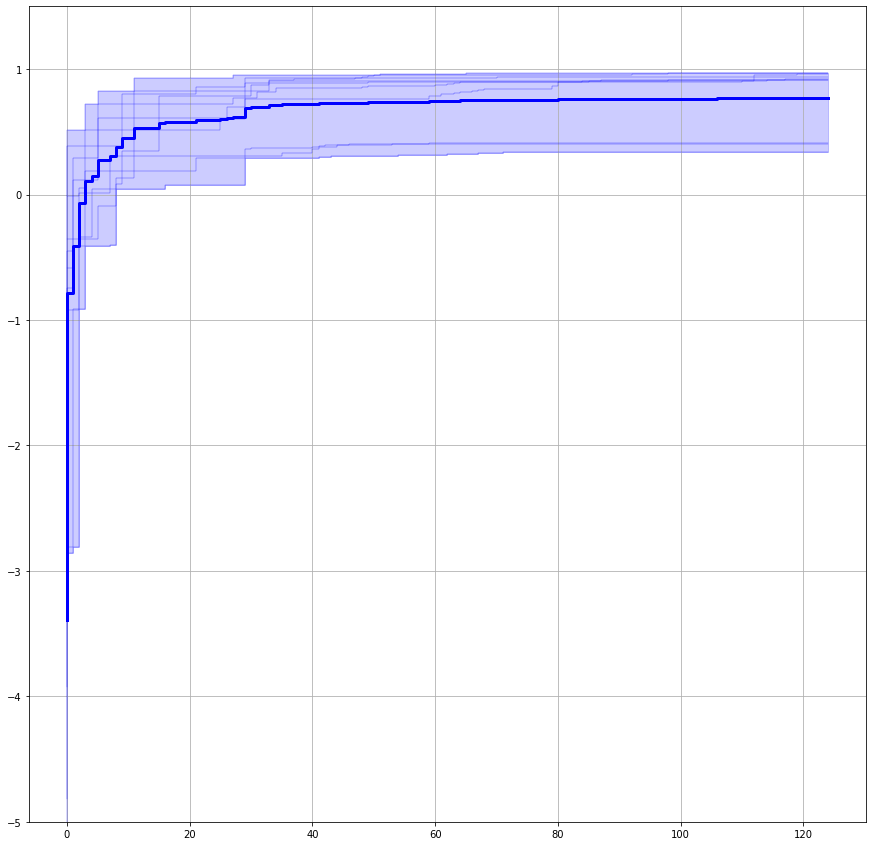

3


In [14]:
import matplotlib.pyplot as plt
from scipy import stats

plt.rcParams['figure.figsize'] = [15, 15]

fig, ax = plt.subplots()
iters = range(0, len(results[0]))

for r in results:
    ax.step(iters, r, color='blue', linewidth=0.3)

results = np.array(results)
#print(results.shape[0])

results_mean = np.mean(results, axis=0)
results_std = np.std(results, axis=0)

ax.step(iters, results_mean, color='blue', linewidth=3)
ax.fill_between(iters, 
                np.min(results, axis=0),
                np.max(results, axis=0),
                color='blue',
                alpha=0.2,
                step='pre'
               )

ax.grid(True)
ax.set_ylim((-5, 1.5))

plt.show()

Now let's plot cluster centers for best trajectory result.

In [18]:
best_pairs = [(results[i][-1], i) for i in range(0, len(results))]
best_tr_idx = sorted(best_pairs, key=lambda x: x[0])[-1][1]

hints = {'w': np.ones(clusters)/clusters, 'mean': mean, 'cov': cov}
#print(hints)

gmm = GMMLikelihoodDispatch(clusters, samples, hints)

print(p := gmm.unpack(opt_data[best_tr_idx].max['params']))

(array([0.33333333, 0.33333333, 0.33333333]), array([[0.91353909, 0.63211516],
       [0.74327504, 0.67271385],
       [0.66213979, 0.90685837]]), array([[[2.64283345e-04, 3.61515054e-06],
        [3.61515054e-06, 2.00146331e-04]],

       [[2.57294327e-03, 1.27945491e-03],
        [1.27945491e-03, 1.62793213e-03]],

       [[1.90633780e-03, 5.91577522e-04],
        [5.91577522e-04, 6.97954468e-04]]]))


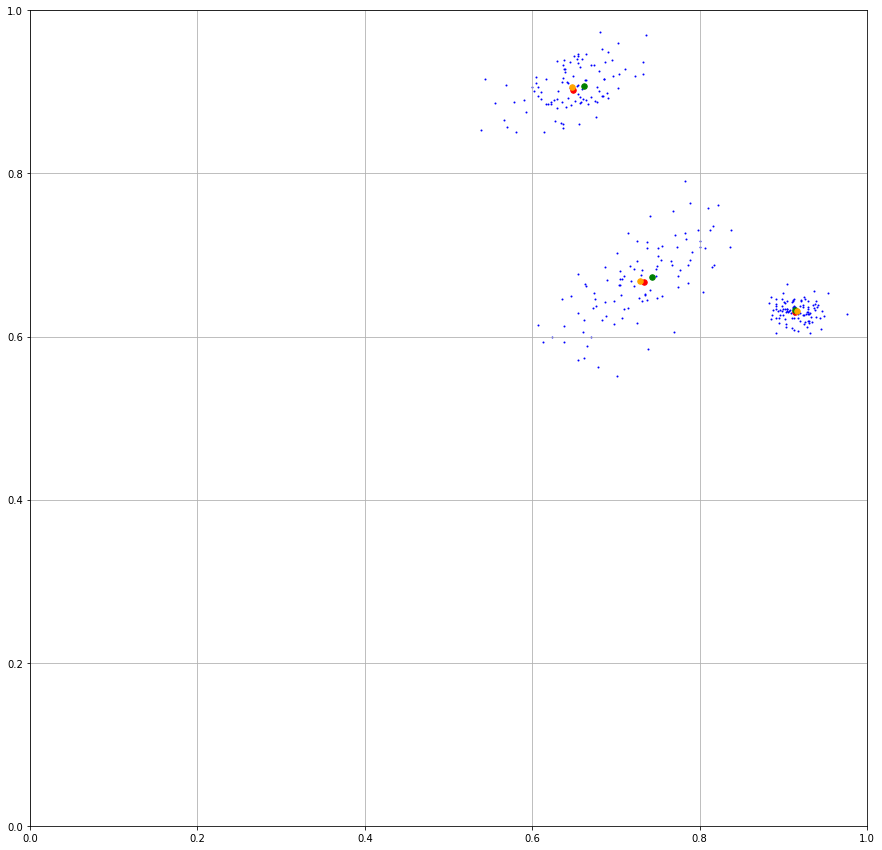

In [19]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=clusters, random_state=0).fit(samples)

plt.rcParams['figure.figsize'] = [15, 15]

fig, ax = plt.subplots()

ax.scatter(samples[:, 0], samples[:, 1], color='blue', s=1)
ax.scatter(mean[:, 0], mean[:, 1], color='red', s=30) # true
ax.scatter(p[1][:, 0], p[1][:, 1], color='green', s=30) # BO result
ax.scatter(gm.means_[:, 0], gm.means_[:, 1], color='orange', s=30) # sklearn

ax.set_xlim((0, 1))
ax.set_ylim((0, 1))
ax.grid(True)

plt.show()